In [125]:
import pandas as pd
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import warnings
import sys
sys.path.append('/home/jovyan/work/d2l_solutions/notebooks/exercises/d2l_utils/')
import d2l
warnings.filterwarnings('ignore')


class SoftmaxRegression(d2l.Classifier):
    def __init__(self, num_outputs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(),
                                  nn.LazyLinear(num_outputs))
        
    def forward(self, X):
        return self.net(X)
    
    def loss(self, y_hat, y, averaged=True):
        y_hat = y_hat.reshape((-1, y_hat.shape[-1]))
        y = y.reshape((-1,))
        return F.cross_entropy(y_hat, y, reduction='mean' 
                               if averaged else 'none')

(105.10649853944778, 19.00413277745247)

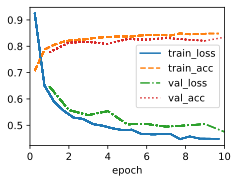

In [13]:
data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegression(num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

# 4.5.5. Exercises

## 1. Deep learning uses many different number formats, including FP64 double precision (used extremely rarely), FP32 single precision, BFLOAT16 (good for compressed representations), FP16 (very unstable), TF32 (a new format from NVIDIA), and INT8. Compute the smallest and largest argument of the exponential function for which the result does not lead to numerical underflow or overflow.

| Number Format    | Smallest Argument           | Largest Argument           |
|------------------|-----------------------------|----------------------------|
| FP64 Double Precision | $-\log(\text{MAX_FP64})$| $\log(\text{MAX_FP64})$  |
| FP32 Single Precision | $-\log(\text{MAX_FP32})$ | $ \log(\text{MAX_FP32})$ |
| BFLOAT16          | $-\log(\text{MAX_BFLOAT16})$ |$\log(\text{MAX_BFLOAT16})$ |
| FP16 Half Precision | $-\log(\text{MAX_FP16})$ | $ \log(\text{MAX_FP16})$  |
| TF32              | $-\log(\text{MAX_TF32})$|$\log(\text{MAX_TF32})$|
| INT8              | N/A (integer format)        | N/A (integer format)       |

In the table above, $\text{MAX_FP64}$, $\text{MAX_FP32}$, $\text{MAX_BFLOAT16}$, $\text{MAX_FP16}$, and $\text{MAX_TF32}$ represent the largest finite values that can be represented in each respective number format. The values are determined by the specific characteristics of the floating-point representation on the hardware and software platform. Keep in mind that these values are approximations and can vary based on the specific implementation.

In [122]:
def get_type_info(t):
    min_num, max_num = 0, 0
    if t == torch.int8:
        min_num, max_num = torch.iinfo(t).min, torch.iinfo(t).max
    else:
        min_num, max_num = torch.finfo(t).min, torch.finfo(t).max
    if t not in [torch.int8, torch.float16]:
        exp_max = torch.log(torch.tensor(max_num, dtype=t))
    else:
        exp_max = torch.log(torch.tensor(max_num))
    test_min = torch.exp(torch.tensor(min_num))
    test_max = torch.exp(exp_max-1)
    nan_max = torch.exp(exp_max+1)
    # test_max = max_num
    return min_num, max_num, min_num, exp_max.item(), test_min.item(), test_max.item(), nan_max.type(t).item()

formats = [torch.float64, torch.float32,
                    torch.bfloat16, torch.float16, torch.int8]
df = pd.DataFrame({'format':formats})
df[['format_min','format_max','exp_min', 'exp_max', 'test_min', 'exp(max-1)', 'exp(max+1)']] = df.apply(lambda x:get_type_info(x[0]),result_type="expand",axis=1)
df

,format,format_min,format_max,exp_min,exp_max,test_min,exp(max-1),exp(max+1)
0,torch.float64,-1.797693e+308,1.797693e+308,-1.797693e+308,709.782713,0.0,6.613343e+307,inf
1,torch.float32,-3.402823e+38,3.402823e+38,-3.402823e+38,88.722839,0.0,1.251829e+38,inf
2,torch.bfloat16,-3.389531e+38,3.389531e+38,-3.389531e+38,88.500000,0.0,1.003567e+38,inf
3,torch.float16,-6.550400e+04,6.550400e+04,-6.550400e+04,11.089867,0.0,2.409758e+04,inf
4,torch.int8,-1.280000e+02,1.270000e+02,-1.280000e+02,4.844187,0.0,4.672070e+01,89.0


Note that **exp(max+1)** of `int8` is not `nan`, that is because:

In Python, when performing operations like addition or subtraction on the **int8** data type, if the result goes beyond the representation range of int8 (-128 to 127), an overflow occurs. Python applies a modulo operation by 256 to the result, **wrapping the overflowed part "around"**, to ensure that the result remains within the int8 range. This cyclic handling of overflow may lead to unexpected results, so special attention is required when working with int8 operations.

## 2. INT8 is a very limited format consisting of nonzero numbers from 1 to 255. How could you extend its dynamic range without using more bits? Do standard multiplication and addition still work?

one potential approach is to use data normalization and denormalization. This won't truly extend the dynamic range of `int8`, but it can allow you to map a wider range of original values to the limited range of `int8` in a meaningful way.

Here's a basic idea of how you might approach this:

1. **Normalization:** Scale down your original data values to fit within the range of -128 to 127. You can choose a scaling factor that maps the maximum value in your data to 127 and scales the rest of the values accordingly. This ensures that your data can be represented within the `int8` range.

2. **Denormalization:** When you need to use the data, reverse the normalization process. Multiply the normalized value by the inverse of the scaling factor and then add any offset if necessary. This will bring the values back to their original range.

However, keep in mind that this approach is not truly extending the dynamic range of `int8`. It's essentially remapping your data to fit within the limited range of `int8`, which may introduce precision loss. This technique is useful when you want to represent data that has a larger dynamic range within the constraints of `int8`.

If you require a truly expanded dynamic range, you would need to use data types with more bits, such as `int16`, `int32`, or `float`, which can represent larger values without compromising precision.

## 3. Increase the number of epochs for training. Why might the validation accuracy decrease after a while? How could we fix this?

Increasing the number of epochs during training can be beneficial for improving the model's performance initially, as it allows the model to learn from the data more thoroughly. However, after a certain point, increasing the number of epochs excessively can lead to overfitting. Overfitting occurs when the model starts to memorize the training data rather than learning general patterns, which can cause a decrease in validation accuracy.

The reasons for a decrease in validation accuracy after a certain number of epochs include:

1. **Overfitting:** The model becomes too specialized to the training data and loses the ability to generalize to unseen data, leading to poor performance on the validation set.

2. **Learning Rate Schedule:** If a learning rate schedule is not used, the learning rate might become too large as training progresses, causing the model to overshoot the optimal weights and converge to a suboptimal solution.

3. **Convergence to Local Minimum:** The model might converge to a local minimum in the loss landscape instead of finding the global minimum, causing validation performance to degrade.

To address the decrease in validation accuracy, you can consider the following strategies:

1. **Early Stopping:** Monitor the validation accuracy during training and stop training when the validation accuracy starts to degrade. This helps prevent overfitting by selecting a model with the best validation performance.

2. **Learning Rate Scheduling:** Use learning rate schedules that decrease the learning rate as training progresses. This can help the model converge more effectively without overshooting the optimal weights.

3. **Regularization:** Apply regularization techniques such as dropout or L2 regularization to prevent the model from becoming too sensitive to the training data.

4. **Data Augmentation:** Introduce data augmentation techniques to artificially increase the diversity of the training data and reduce overfitting.

5. **Model Architecture:** Consider using a simpler model architecture or applying techniques like batch normalization to improve the model's generalization ability.

Balancing the number of training epochs and preventing overfitting is crucial to achieving good generalization performance on unseen data. It's important to monitor the validation accuracy and adjust hyperparameters accordingly to strike the right balance between training and overfitting.

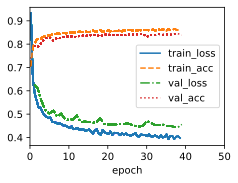

In [ ]:
data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegression(num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=50)
trainer.fit(model, data)

## 4. What happens as you increase the learning rate? Compare the loss curves for several learning rates. Which one works better? When?

In [ ]:
data = d2l.FashionMNIST(batch_size=256)
lrs = [0.001,0.01,0.03,0.1,0.3,1]
train_loss, valid_loss = [],[]
for lr in lrs:
    model = SoftmaxRegression(num_outputs=10, lr=lr)
    trainer = d2l.Trainer(max_epochs=10, plot_flag=False)
    temp = trainer.fit(model, data)
    train_loss.append(temp[0])
    valid_loss.append(temp[1])

In [ ]:
plt.subplot(1,2,1)
plt.plot(lrs, train_loss, label='train_loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(lrs, valid_loss, label='valid loss')
plt.legend()
plt.show()

As you increase the learning rate during training, the model's weights are updated more significantly after each iteration, causing faster convergence but potentially leading to overshooting the optimal weights and divergence. The effect of increasing the learning rate can vary depending on the dataset, the model architecture, and other hyperparameters.

When comparing loss curves for several learning rates, you may observe the following scenarios:

1. **Small Learning Rate:** A small learning rate results in slow convergence and might get stuck in local minima. The loss curve may show a gradual decrease, but the convergence process can be slow.

2. **Optimal Learning Rate:** An optimal learning rate allows the model to converge smoothly and reach a low loss. The loss curve may show a steady decline with no signs of overshooting or divergence.

3. **Large Learning Rate:** A large learning rate can cause the loss curve to show oscillations, erratic behavior, and even divergence. The loss may increase instead of decreasing, indicating that the weights are bouncing around without converging.

Selecting the best learning rate depends on experimentation and observation of the loss curves during training. A learning rate that works well for one dataset or model architecture might not work as effectively for another. It's common practice to perform a learning rate search by training the model with different learning rates and evaluating their performance on a validation set.

In general:

- If the learning rate is too small, the model might take a long time to converge.
- If the learning rate is too large, the model might diverge or show unstable behavior.
- An appropriate learning rate will result in a loss curve that steadily decreases without oscillations or divergence.

Techniques such as learning rate scheduling (reducing the learning rate during training) and using adaptive learning rate algorithms (e.g., Adam, RMSprop) can help mitigate the challenges associated with selecting a fixed learning rate. These methods adjust the learning rate dynamically during training to balance convergence speed and stability.